In [1]:
## Visualize the trained model

import sys
#sys.path.append('deps/sparse_rrt')
sys.path.append('.')
import torch
import torch.nn as nn
import importlib
#from model import ae_s2d
#from model import cvae_s2d_model1 as cvae_s2d

from model.SMPNet import SMPNet
#from tools import data_loader
from tools.utility import *
#from plan_utility import cart_pole, cart_pole_obs, pendulum, acrobot_obs, car_obs
import argparse
import numpy as np
import random
import os
from tqdm import tqdm, trange


In [2]:
import yaml
# try:
#     from yaml import CLoader as Loader, CDumper as Dumper
# except ImportError:
#     from yaml import Loader, Dumper

parser = argparse.ArgumentParser()
# for training
parser.add_argument('--param_path', type=str, default='param/train/',help='path for loading training param')
parser.add_argument('--param_name', type=str, default="cvae_s2d_param1.yaml")

# parse the parameter file
args = parser.parse_args("")
print(args)
param_f = open(args.param_path+args.param_name, 'r')
param = yaml.load(param_f)
param = DictDot(param)
args = param
args.start_epoch = 3
args.s = 0
args.sp = 4000
args.start_iter = 5000

Namespace(param_name='cvae_s2d_param1.yaml', param_path='param/train/')


<ipython-input-2-ee31d91686e0>:16: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  param = yaml.load(param_f)


In [3]:
if torch.cuda.is_available():
    torch.cuda.set_device(args.device)
# environment setting
cae = None
mlp = None

# load net
# load previously trained model if start epoch > 0

# dynamically import model
ae_module = importlib.import_module('model.ae_%s_model_%d' % (args.env_type, args.model_id))
cvae_module = importlib.import_module('model.cvae_%s_model_%d' % (args.env_type, args.model_id))
e_net = ae_module.Encoder(input_size=args.e_net_input_size, output_size=args.e_net_output_size)
cvae = cvae_module.CVAE(input_size=args.input_size, latent_size=args.latent_size, cond_size=args.cond_size)

data_loader = importlib.import_module('tools.data_loader_%s' % (args.env_type))
plan_util = importlib.import_module('plan_util.%s' % (args.env_type))
normalize = plan_util.normalize
unnormalize = plan_util.unnormalize

smpnet = SMPNet(e_net, cvae)
model_dir = args.model_dir + '%s/model_%d/param_%s/' % (args.env_type, args.model_id, args.param_name)
model_path='smpnet_epoch_%d_iter_%d.pkl' %(args.start_epoch, args.start_iter)
torch_seed, np_seed, py_seed = 0, 0, 0
if args.start_epoch > 0:
    load_net_state(smpnet, os.path.join(model_dir, model_path))
    torch_seed, np_seed, py_seed = load_seed(os.path.join(model_dir, model_path))
    # set seed after loading
    torch.manual_seed(torch_seed)
    np.random.seed(np_seed)
    random.seed(py_seed)

if torch.cuda.is_available():
    smpnet.cuda()
    smpnet.cvae.cuda()
    smpnet.e_net.cuda()
    if args.opt == 'Adagrad':
        smpnet.set_opt(torch.optim.Adagrad, lr=args.learning_rate)
    elif args.opt == 'Adam':
        smpnet.set_opt(torch.optim.Adam, lr=args.learning_rate)
    elif args.opt == 'SGD':
        smpnet.set_opt(torch.optim.SGD, lr=args.learning_rate, momentum=0.9)
    elif args.opt == 'ASGD':
        smpnet.set_opt(torch.optim.ASGD, lr=args.learning_rate)
if args.start_epoch > 0:
    load_opt_state(smpnet, os.path.join(model_dir, model_path))
data_folder = args.data_folder+args.env_type+'/'


length of the output of one encoder
343


In [4]:
# test to see the error
waypoint_dataset, start_dataset, goal_dataset, obs, start_indices, goal_indices, env_indices \
         = data_loader.load_train_dataset(N=10, NP=200, s=0, sp=0,
                                            data_folder=data_folder)
start_dataset, goal_dataset = np.array(start_dataset), np.array(goal_dataset)

# randomize the dataset before training
data=list(zip(waypoint_dataset, start_indices, goal_indices, env_indices))
random.shuffle(data)
waypoint_dataset,start_indices,goal_indices,env_indices=list(zip(*data))
waypoint_dataset = list(waypoint_dataset)
start_indices = list(start_indices)
goal_indices = list(goal_indices)
env_indices = list(env_indices)
waypoint_dataset = np.array(waypoint_dataset)
start_indices, goal_indices, env_indices = np.array(start_indices), np.array(goal_indices), np.array(env_indices)

smpnet.eval()
epoch_val_num = 2048
waypoint_dataset_i = waypoint_dataset[:epoch_val_num]
start_indices_i, goal_indices_i, env_indices_i = start_indices[:epoch_val_num], \
                                                goal_indices[:epoch_val_num], \
                                                env_indices[:epoch_val_num]
bi = waypoint_dataset_i
bi = torch.FloatTensor(bi)
bi = normalize(bi, args.world_size)
bi=to_var(bi)
y_start_i = start_dataset[start_indices_i]
y_goal_i = goal_dataset[goal_indices_i]
y_start_i, y_goal_i = torch.FloatTensor(y_start_i), torch.FloatTensor(y_goal_i)
y_start_i, y_goal_i = normalize(y_start_i, args.world_size), normalize(y_goal_i, args.world_size)
y_start_i, y_goal_i = to_var(y_start_i), to_var(y_goal_i)
bobs = obs[env_indices_i].astype(np.float32)
bobs = torch.FloatTensor(bobs)
bobs = to_var(bobs)
loss = smpnet.loss(bi, smpnet.train_forward(bi, y_start_i, y_goal_i, bobs), beta=args.beta)
loss = torch.mean(loss)
print('mean loss: %f' % (loss.cpu().item()))



mean loss: 0.454916


In [19]:
obs_idx = 1
path_idx = 100
# test to see the error
waypoint_dataset, start_dataset, goal_dataset, obs, start_indices, goal_indices, env_indices \
         = data_loader.load_train_dataset(N=1, NP=1, s=args.s+obs_idx, sp=args.sp+path_idx,
                                            data_folder=data_folder)
start_dataset, goal_dataset = np.array(start_dataset), np.array(goal_dataset)

# randomize the dataset before training
data=list(zip(waypoint_dataset, start_indices, goal_indices, env_indices))
random.shuffle(data)
waypoint_dataset,start_indices,goal_indices,env_indices=list(zip(*data))
waypoint_dataset = list(waypoint_dataset)
start_indices = list(start_indices)
goal_indices = list(goal_indices)
env_indices = list(env_indices)
waypoint_dataset = np.array(waypoint_dataset)
start_indices, goal_indices, env_indices = np.array(start_indices), np.array(goal_indices), np.array(env_indices)

smpnet.eval()
epoch_val_num = 2048
waypoint_dataset_i = waypoint_dataset[:epoch_val_num]
start_indices_i, goal_indices_i, env_indices_i = start_indices[:epoch_val_num], \
                                                goal_indices[:epoch_val_num], \
                                                env_indices[:epoch_val_num]
bi = waypoint_dataset_i
bi = torch.FloatTensor(bi)
bi = normalize(bi, args.world_size)
bi=to_var(bi)
y_start_i = start_dataset[start_indices_i]
y_goal_i = goal_dataset[goal_indices_i]
y_start_i, y_goal_i = torch.FloatTensor(y_start_i), torch.FloatTensor(y_goal_i)
y_start_i, y_goal_i = normalize(y_start_i, args.world_size), normalize(y_goal_i, args.world_size)
y_start_i, y_goal_i = to_var(y_start_i), to_var(y_goal_i)
bobs = obs[env_indices_i].astype(np.float32)
bobs = torch.FloatTensor(bobs)
bobs = to_var(bobs)

output = smpnet.train_forward(bi, y_start_i, y_goal_i, bobs, L=1)
loss = smpnet.loss(bi, output, beta=args.beta)
loss = torch.mean(loss)
print('mean loss: %f' % (loss.cpu().item()))
gen_loss = smpnet.generation_loss(bi, output)
gen_loss = torch.mean(gen_loss)
print('generation loss: %f' % (gen_loss.cpu().item()))

kl_loss = smpnet.kl_divergence(bi, output)
kl_loss = torch.mean(kl_loss)
print('KL loss: %f' % (kl_loss.cpu().item()))

z_mu,z_log_sigma_pow2, z, x_mu = output
print('reconstruction: ')
print(x_mu)
print(x_mu.size())
print('ground truth:')
print(bi.cpu().data)

mean loss: 0.447980
generation loss: 0.377061
KL loss: 70.918602
reconstruction: 
tensor([[[ -0.3072,  -3.0999],
         [-12.0504,  -9.1996],
         [  0.8373,  -2.5790],
         [ -8.9180,  -7.2260],
         [-16.9664, -12.5732],
         [ -5.1724,  -4.9628],
         [  6.9148,   1.3309],
         [  2.8951,  -1.4780]]], device='cuda:0', grad_fn=<ViewBackward>)
torch.Size([1, 8, 2])
ground truth:
tensor([[ -0.3095,  -3.0742],
        [-13.0586,  -9.8859],
        [  0.8241,  -2.5121],
        [ -9.5003,  -7.7751],
        [-18.5633, -13.5614],
        [ -5.2026,  -5.3847],
        [  7.3045,   1.4199],
        [  2.9992,  -1.3245]])


In [10]:
# load test data
print('loading...')
obs_center, obs, paths, path_lengths = \
        data_loader.load_test_dataset(N=args.no_env, NP=args.no_motion_paths, \
                                      s=args.s, sp=args.sp, folder=data_folder)
obs_width = 5.


loading...


In [11]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def cvae_visualization(smpnet, obs_idx, path_idx, num_sample=10):
    # visualize the planning scene and samples
    obs_center_i = obs_center[obs_idx]
    obs_i = obs[obs_idx]
    path_i = paths[obs_idx][path_idx]
    path_length_i = path_lengths[obs_idx][path_idx]
    #print(path_length_i)
    assert path_length_i > 2
    y_start_i = path_i[0]
    y_goal_i = path_i[path_length_i-1]
    y_start_i, y_goal_i = torch.FloatTensor(y_start_i).unsqueeze(0), torch.FloatTensor(y_goal_i).unsqueeze(0)
    y_start_i, y_goal_i = y_start_i.repeat(num_sample,1), y_goal_i.repeat(num_sample,1)
    y_start_i, y_goal_i = normalize(y_start_i, args.world_size), normalize(y_goal_i, args.world_size)
    y_start_i, y_goal_i = to_var(y_start_i), to_var(y_goal_i)
    
    #print([num_sample]+list(obs_i.shape))
    bobs = torch.FloatTensor(obs_i).unsqueeze(0).repeat([num_sample, 1, 1, 1])
    bobs = to_var(bobs)
    #print(bobs.size())
    # generating
    samples = smpnet.gen_forward(y_start_i, y_goal_i, obs=bobs, obs_z=None)
    samples = samples.cpu().data
    samples = unnormalize(samples, args.world_size).numpy()
    
    # visualize
    # show obstacles
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_xlim(-22, 22)
    ax.set_ylim(-22, 22)
    #print(obs_center_i.shape)

    for i in range(len(obs_center_i)):
        x, y = obs_center_i[i][0], obs_center_i[i][1]
        obs_patch_i = patches.Rectangle((x-obs_width/2,y-obs_width/2),\
                                       obs_width,obs_width,\
                                       linewidth=0.0, facecolor='black')
        ax.add_patch(obs_patch_i)
    
    # show start and goal
    ax.scatter([path_i[0][0]], [path_i[0][1]], c='green', s=100.0)
    ax.scatter([path_i[path_length_i-1][0]], [path_i[path_length_i-1][1]], c='red', s=100.0, marker='*')
    
    # show samples
    ax.scatter(samples[:,0], samples[:,1], c='blue', s=50.)
    return fig

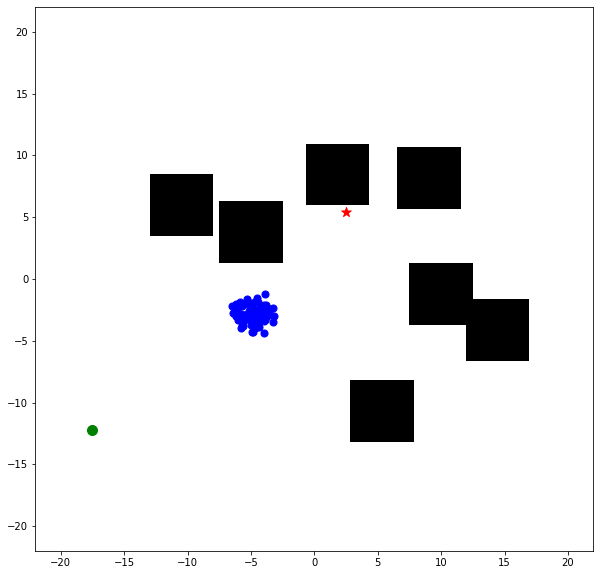

In [12]:
fig = cvae_visualization(smpnet, 1, 140, num_sample=100)
plt.show()


In [13]:
print(path_lengths)

[[ 3  5  9 ...  0  0  0]
 [14  6  9 ...  0  0  0]
 [ 2 17  6 ...  0  0  0]
 ...
 [14  5  6 ...  0  0  0]
 [10 17  7 ...  0  0  0]
 [ 3 21  2 ...  0  0  0]]


In [14]:
model_fs = [f for f in os.listdir(model_dir) if 'smpnet_epoch_' in f and 'iter' in f]
def get_epoch_itr(v_str):
    idx = v_str.split('epoch_')[1]
    idx = idx.split('_iter_')
    epoch = int(idx[0])
    itr = int(idx[1][:-4])
    return (epoch, itr)
model_fs = sorted(model_fs, key=get_epoch_itr)
print(model_fs)

['smpnet_epoch_1_iter_0.pkl', 'smpnet_epoch_1_iter_1000.pkl', 'smpnet_epoch_1_iter_2000.pkl', 'smpnet_epoch_1_iter_3000.pkl', 'smpnet_epoch_1_iter_4000.pkl', 'smpnet_epoch_1_iter_5000.pkl', 'smpnet_epoch_1_iter_6000.pkl', 'smpnet_epoch_1_iter_7000.pkl', 'smpnet_epoch_1_iter_8000.pkl', 'smpnet_epoch_1_iter_9000.pkl', 'smpnet_epoch_2_iter_0.pkl', 'smpnet_epoch_2_iter_1000.pkl', 'smpnet_epoch_2_iter_2000.pkl', 'smpnet_epoch_2_iter_3000.pkl', 'smpnet_epoch_2_iter_4000.pkl', 'smpnet_epoch_2_iter_5000.pkl', 'smpnet_epoch_2_iter_6000.pkl', 'smpnet_epoch_2_iter_7000.pkl', 'smpnet_epoch_2_iter_8000.pkl', 'smpnet_epoch_2_iter_9000.pkl', 'smpnet_epoch_3_iter_0.pkl', 'smpnet_epoch_3_iter_1000.pkl', 'smpnet_epoch_3_iter_2000.pkl', 'smpnet_epoch_3_iter_3000.pkl', 'smpnet_epoch_3_iter_4000.pkl', 'smpnet_epoch_3_iter_5000.pkl', 'smpnet_epoch_3_iter_6000.pkl', 'smpnet_epoch_3_iter_7000.pkl', 'smpnet_epoch_3_iter_8000.pkl', 'smpnet_epoch_3_iter_9000.pkl', 'smpnet_epoch_4_iter_0.pkl', 'smpnet_epoch_4_ite

<ipython-input-11-3c80c93aa1a7>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10,10))


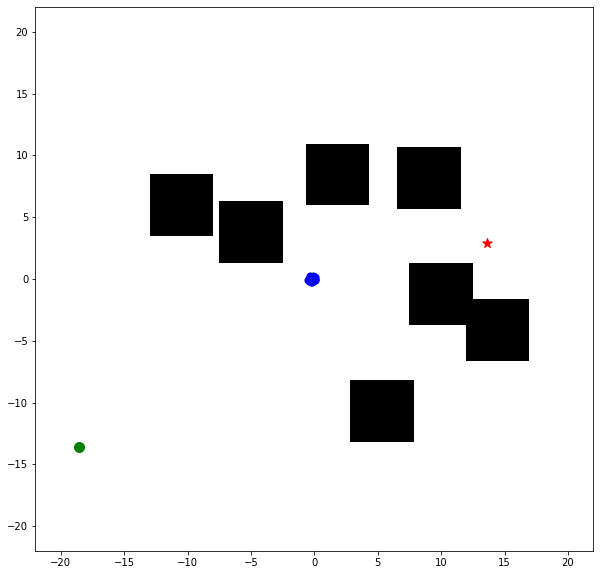

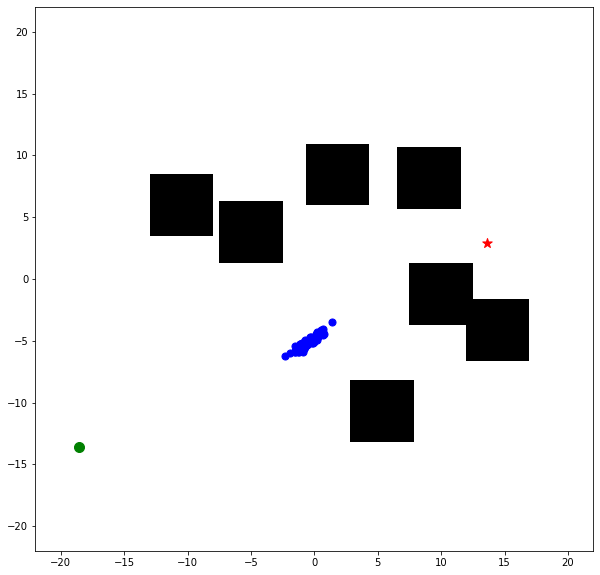

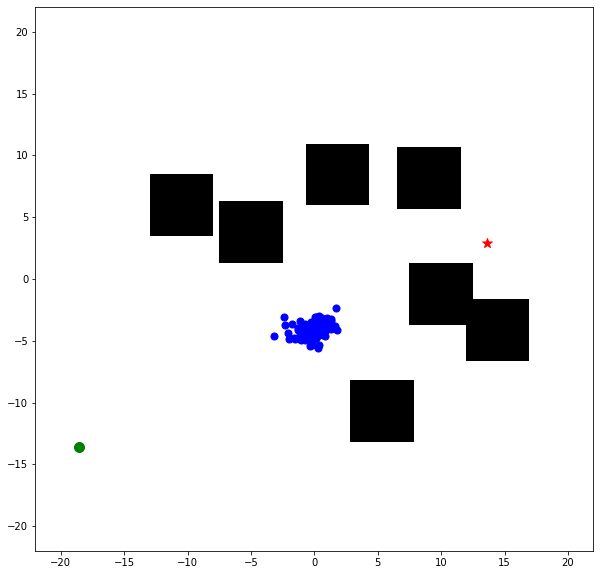

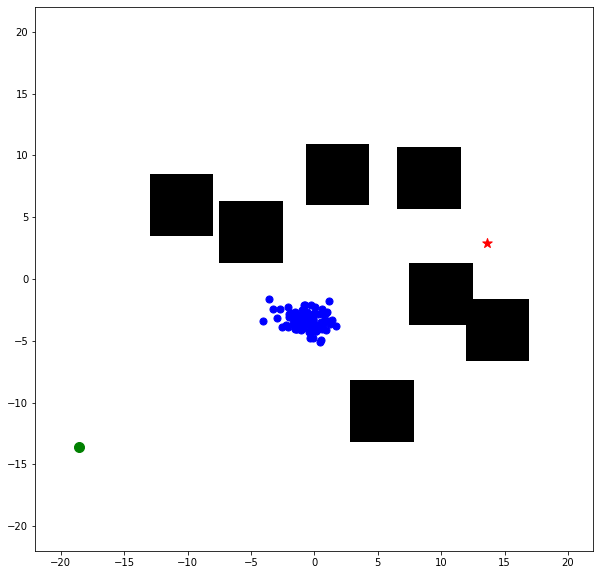

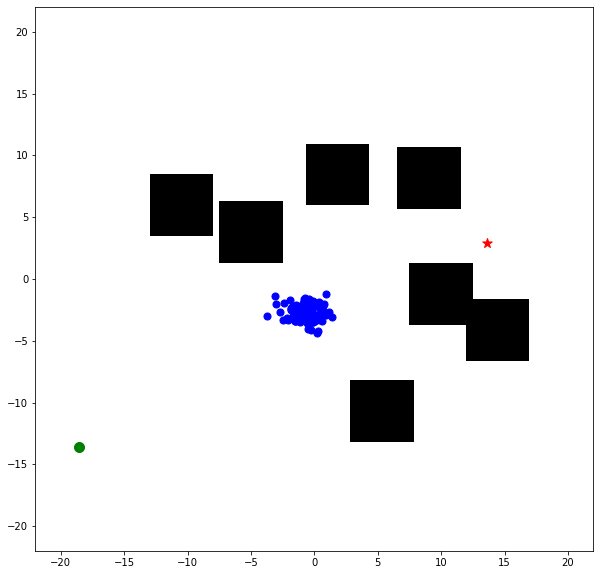

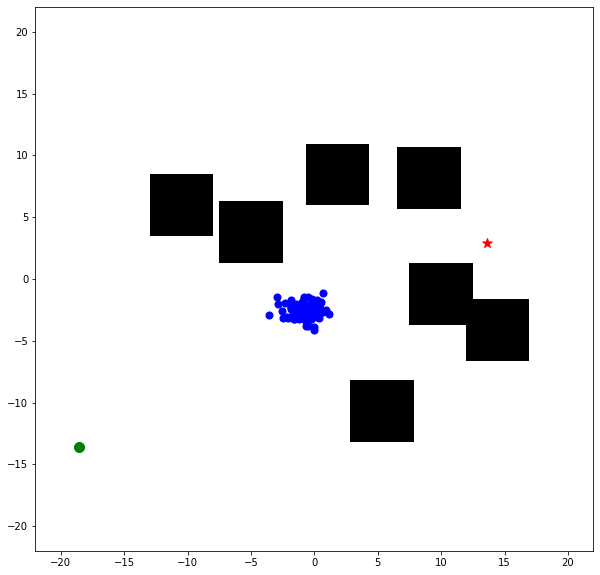

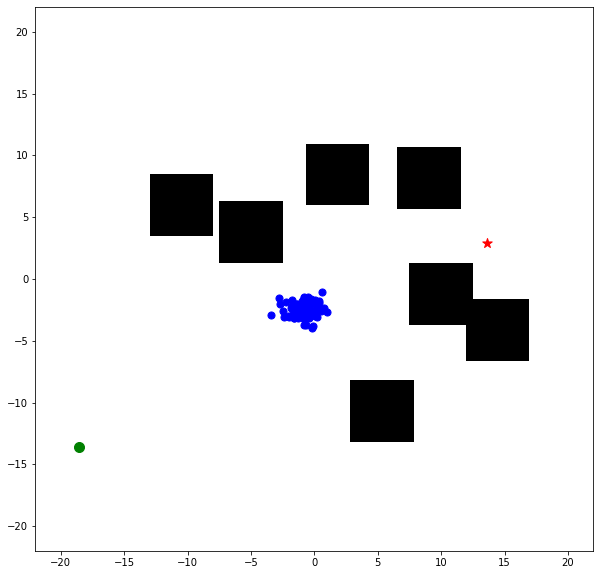

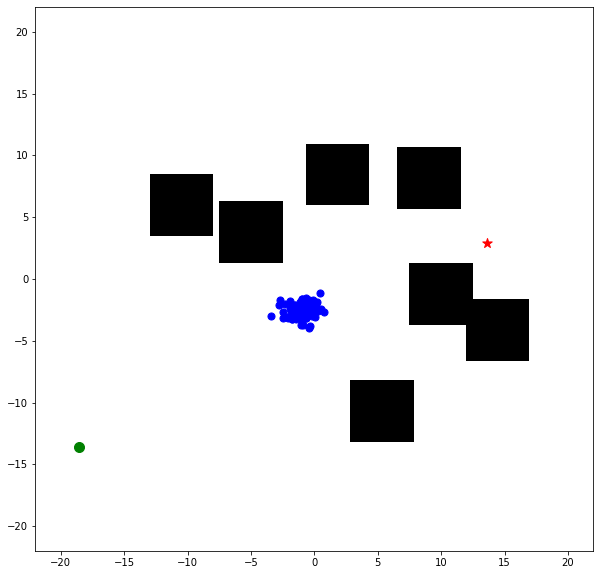

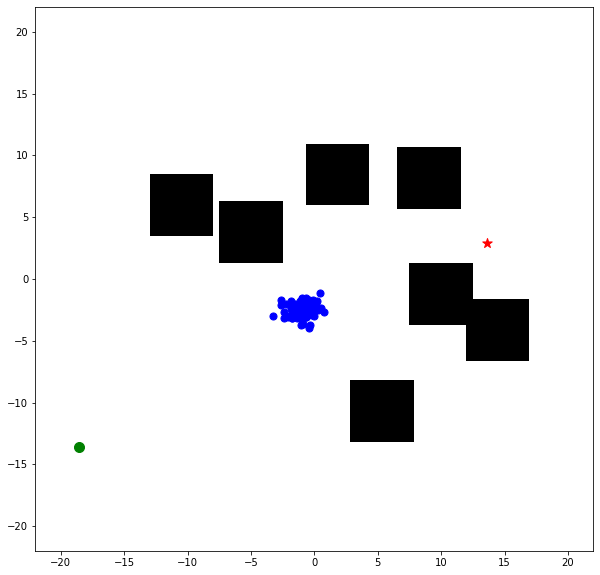

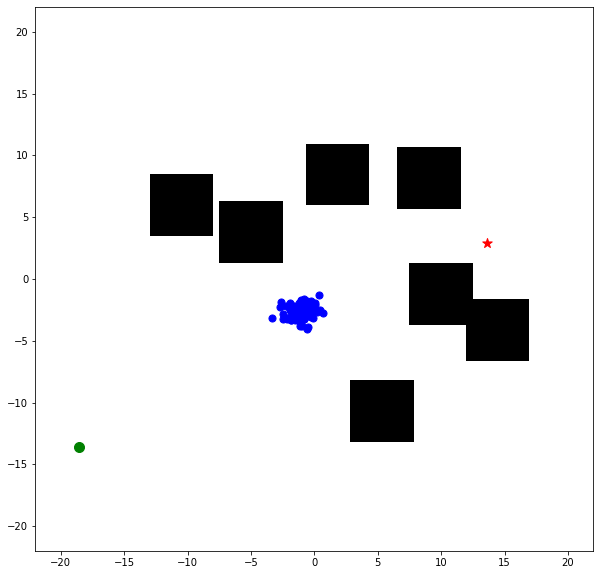

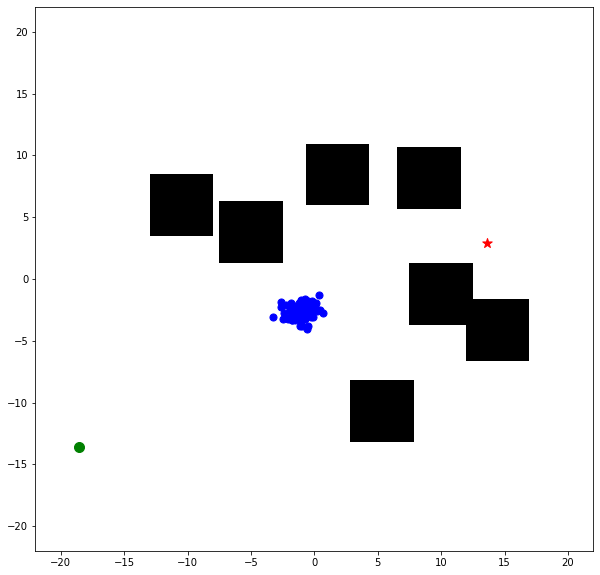

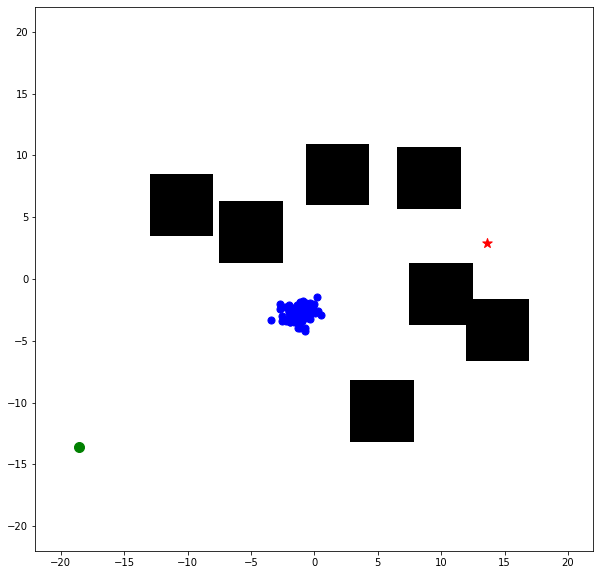

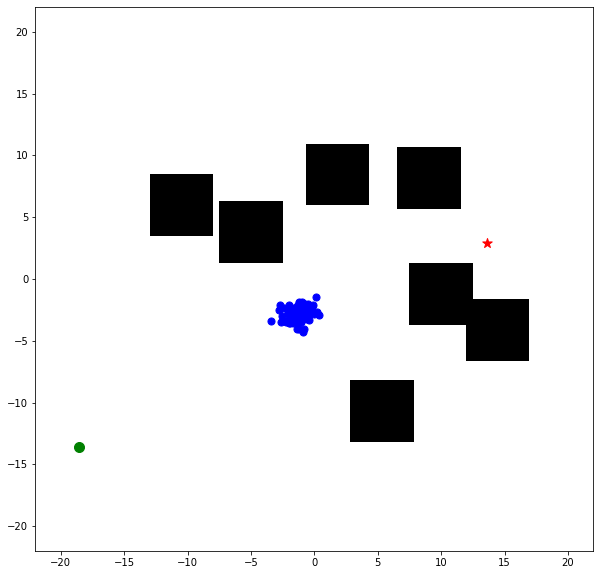

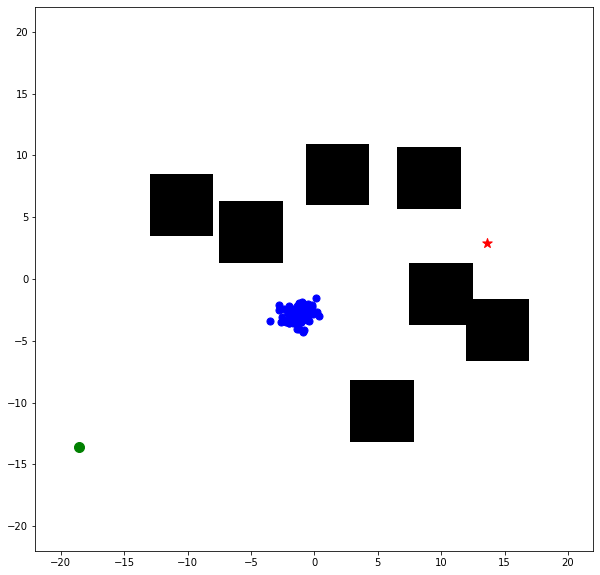

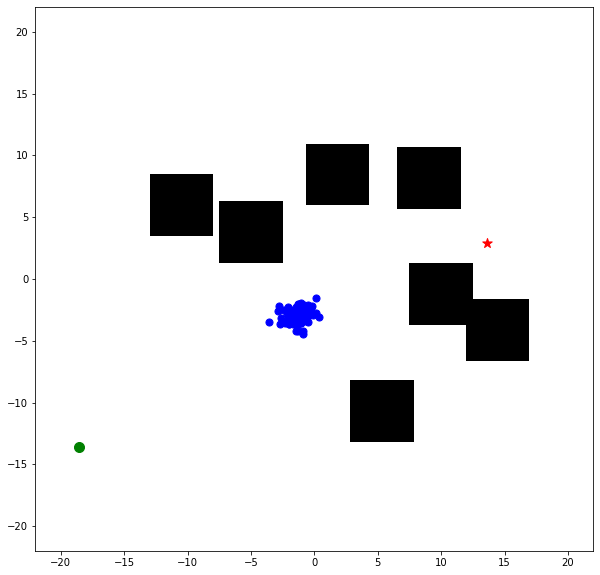

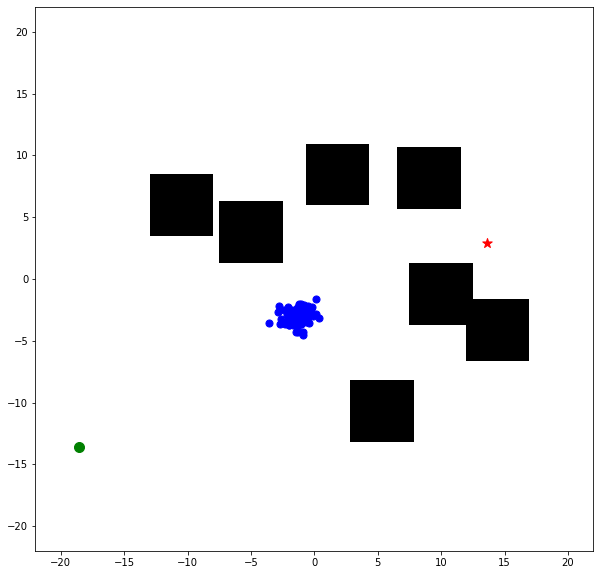

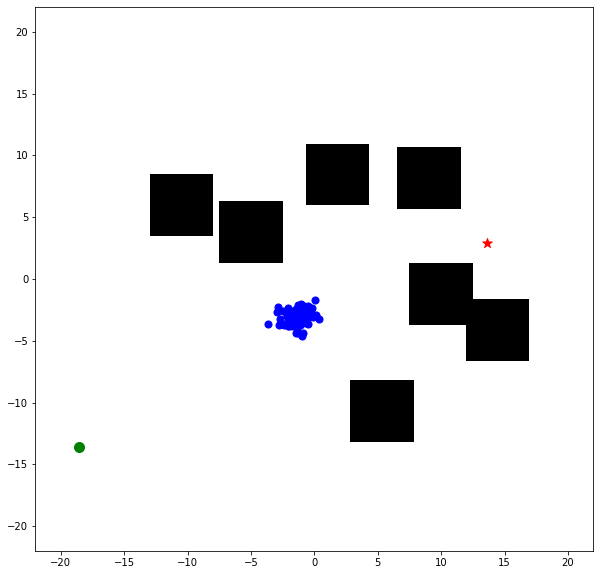

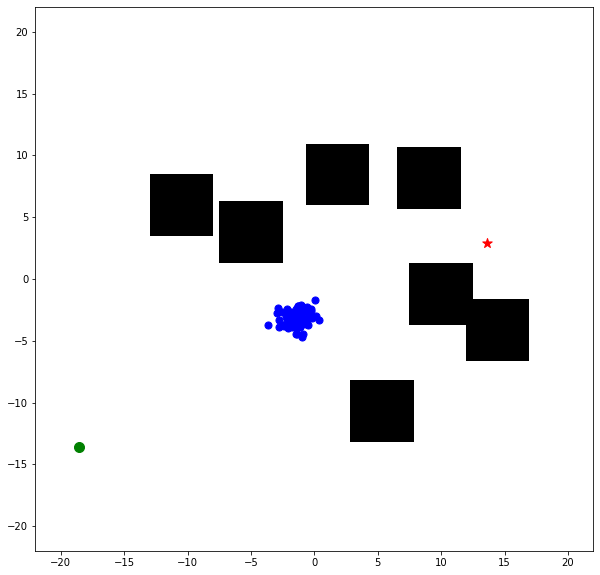

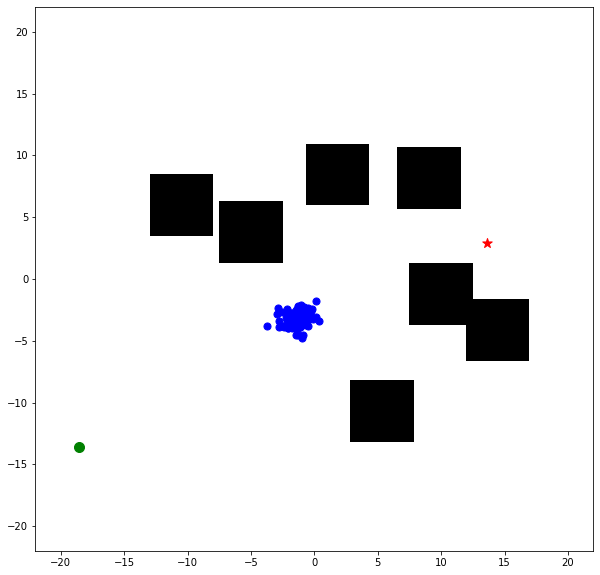

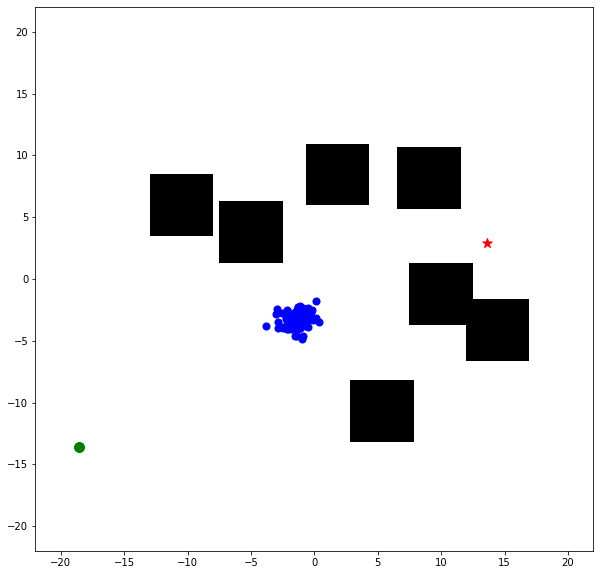

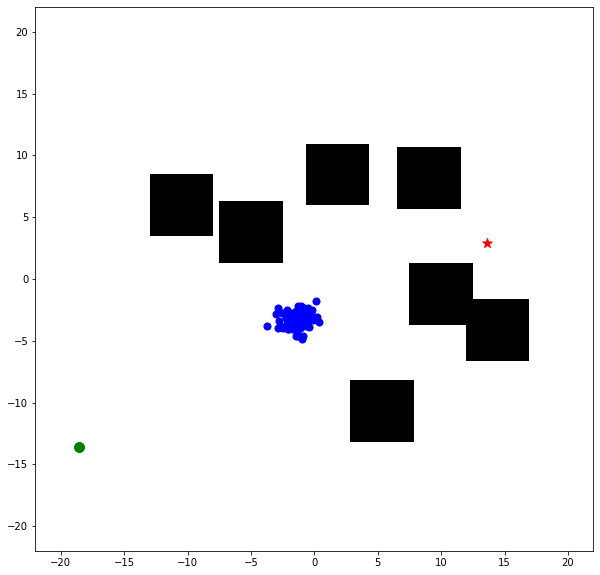

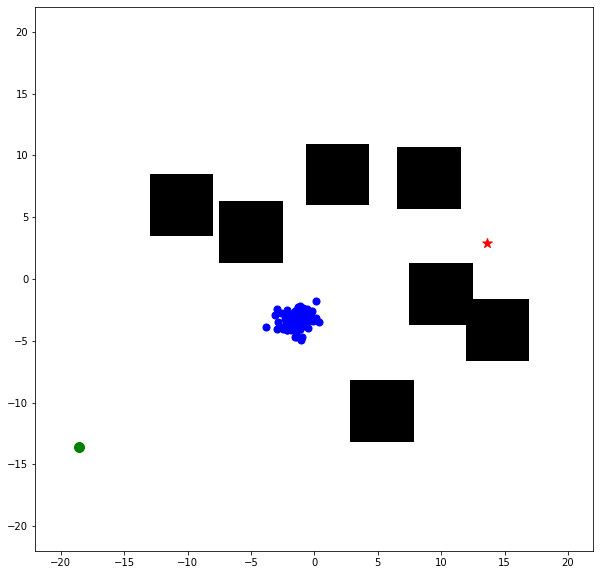

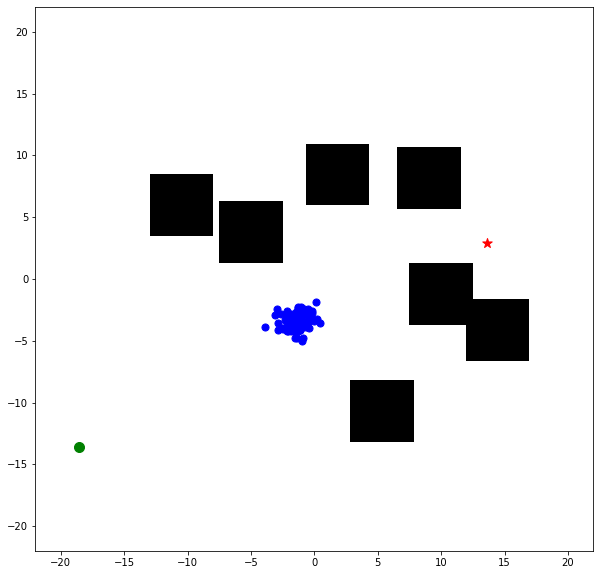

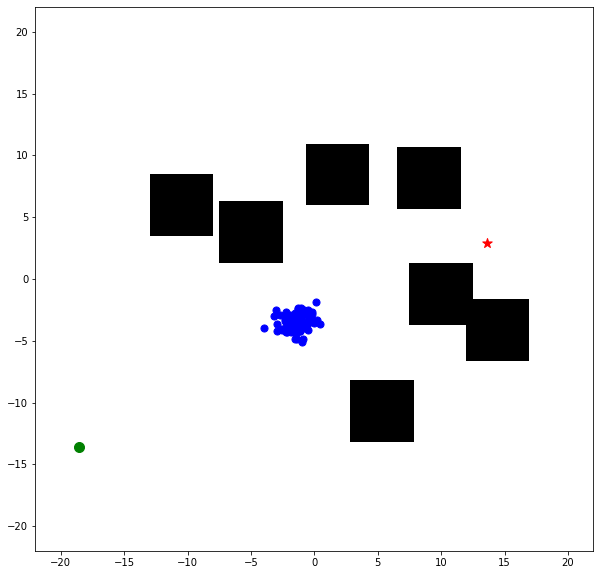

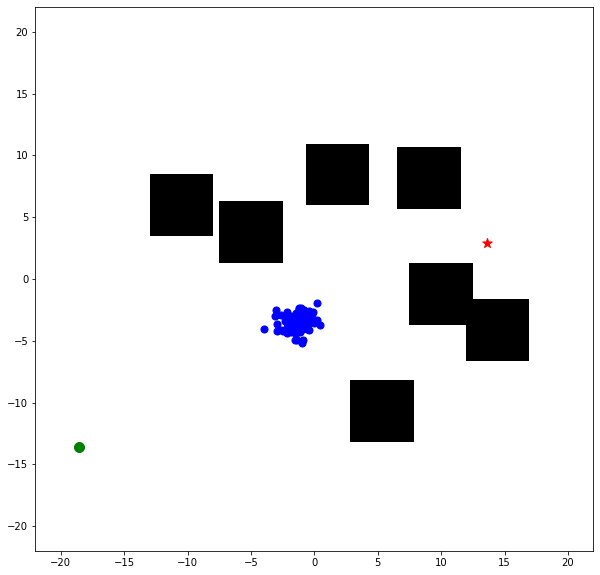

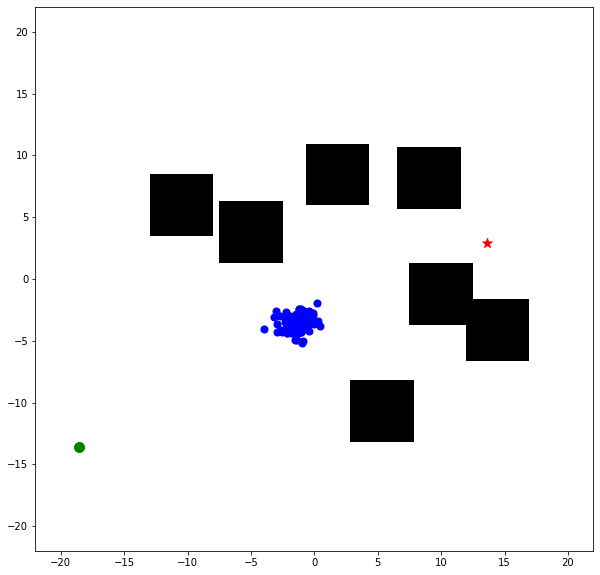

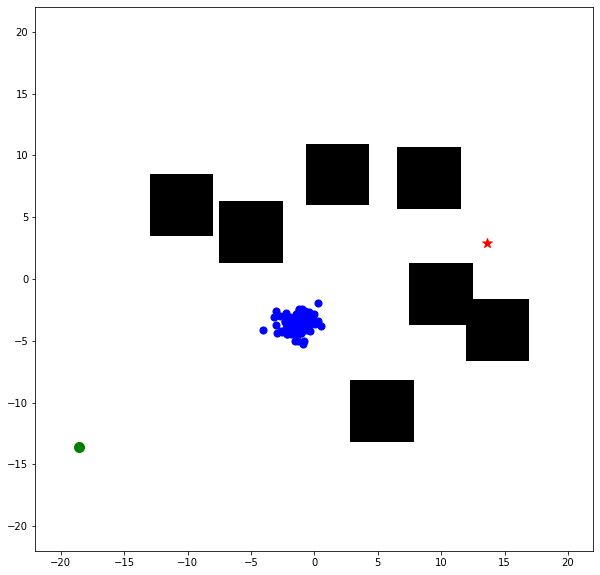

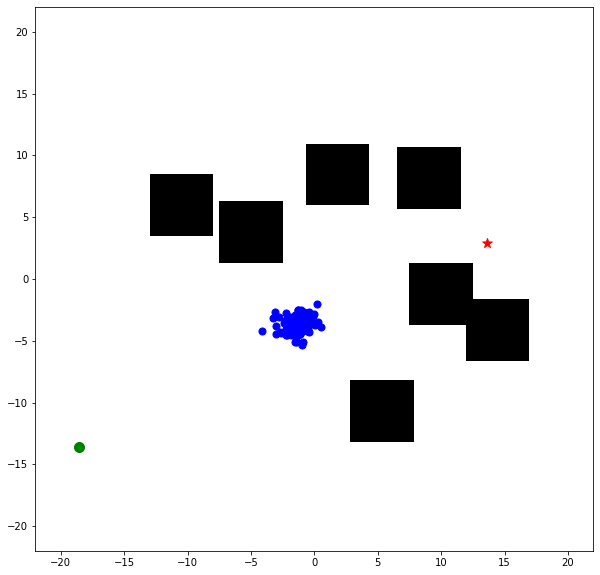

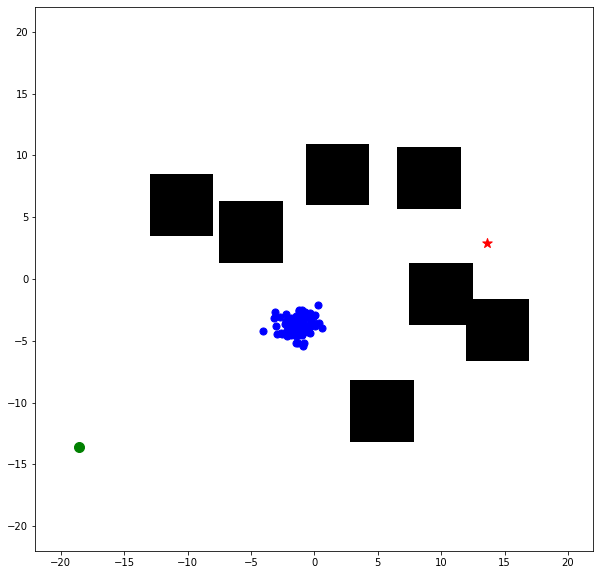

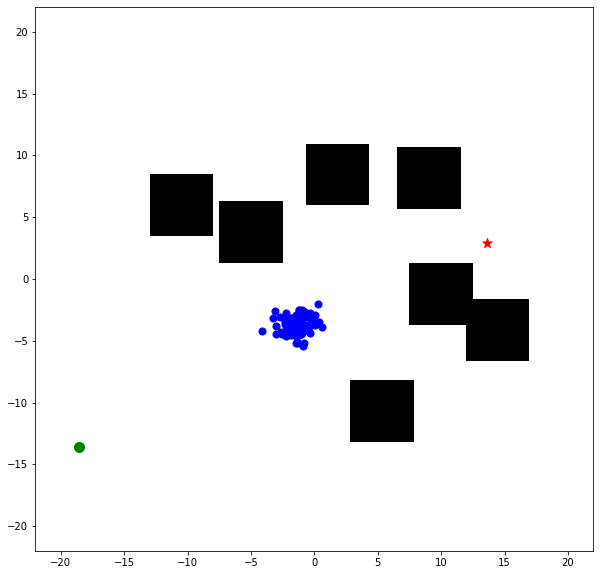

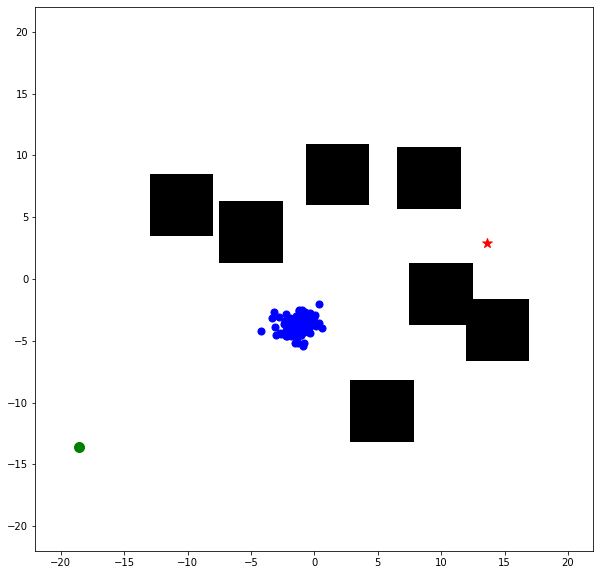

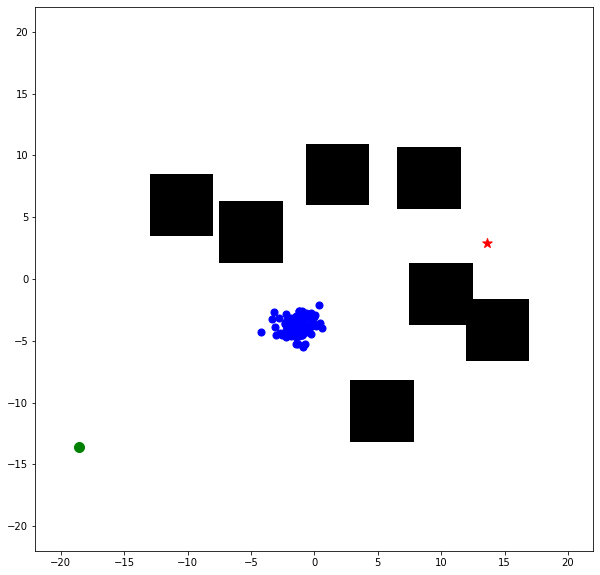

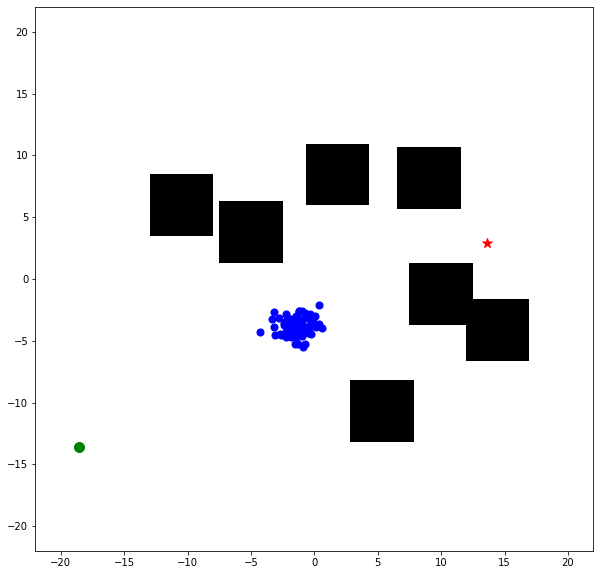

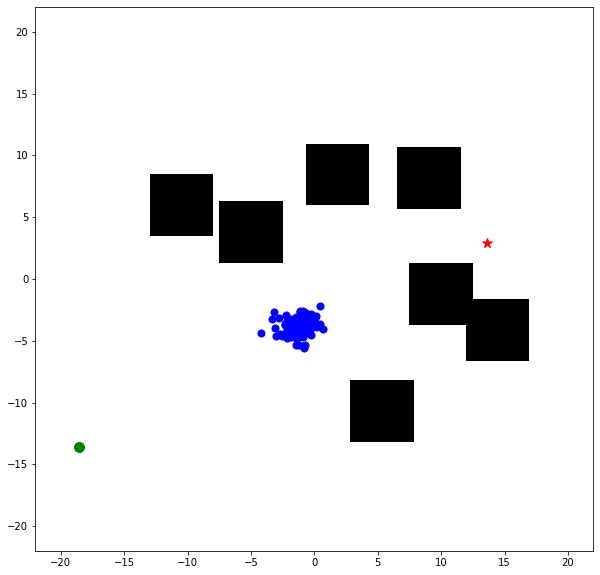

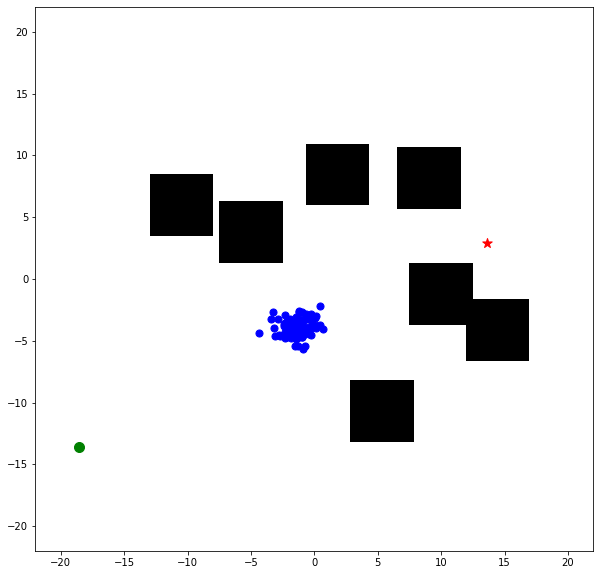

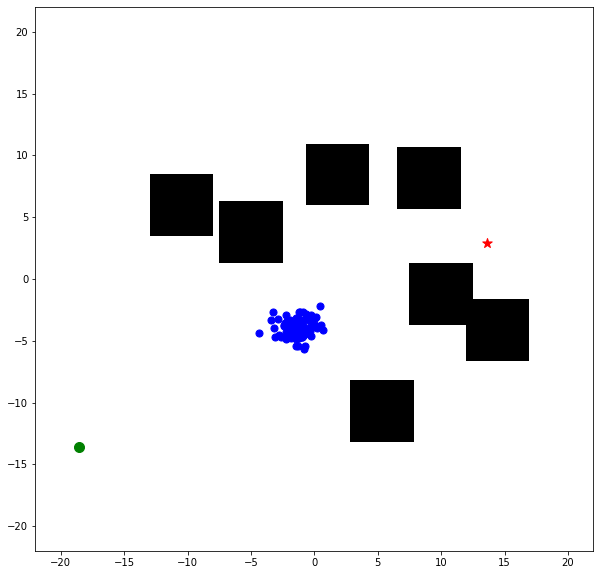

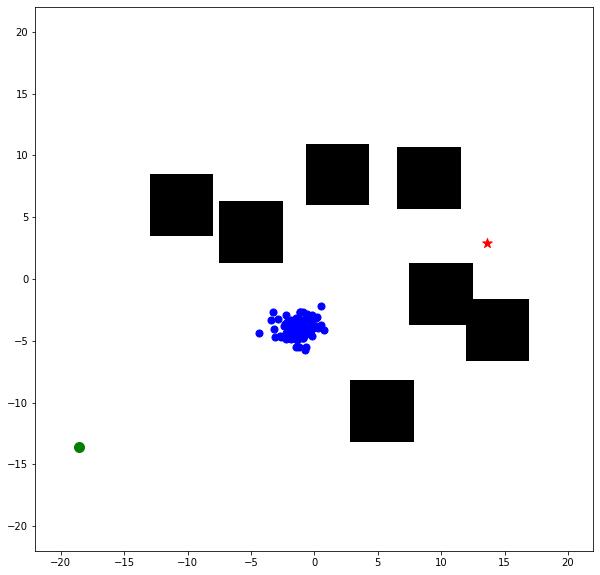

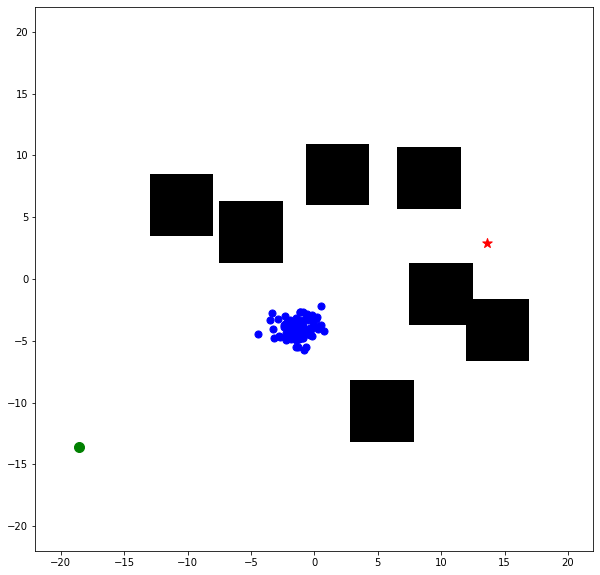

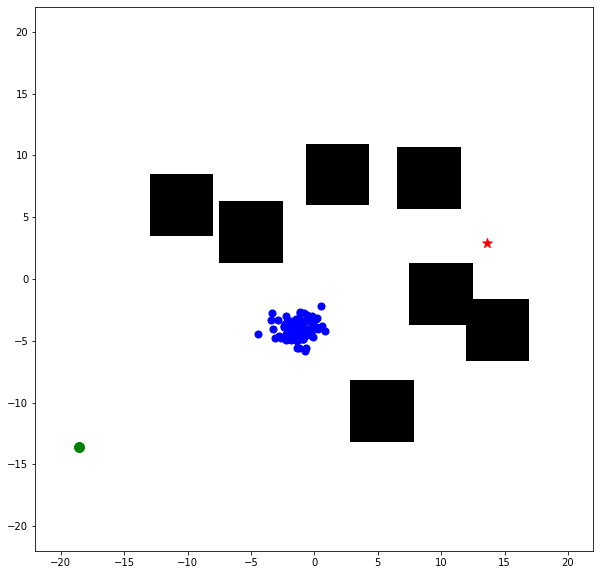

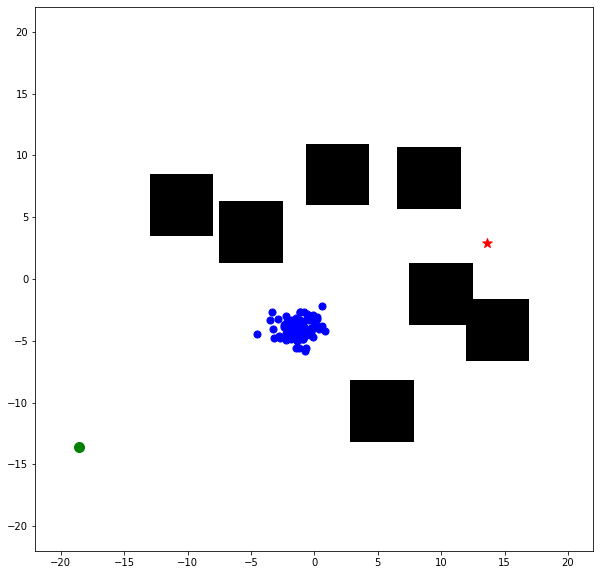

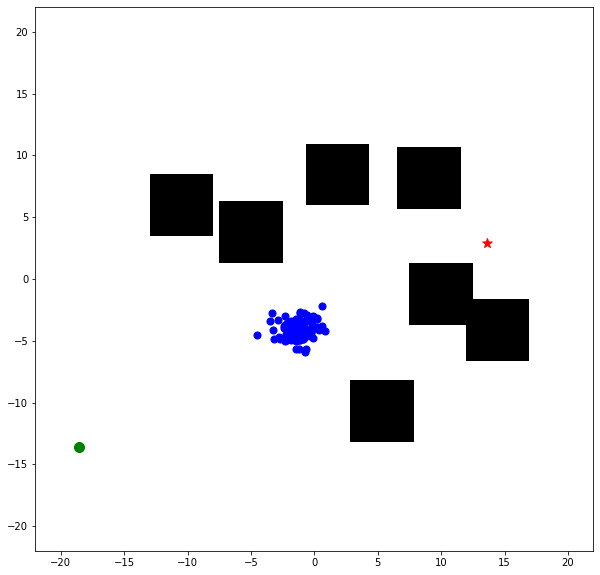

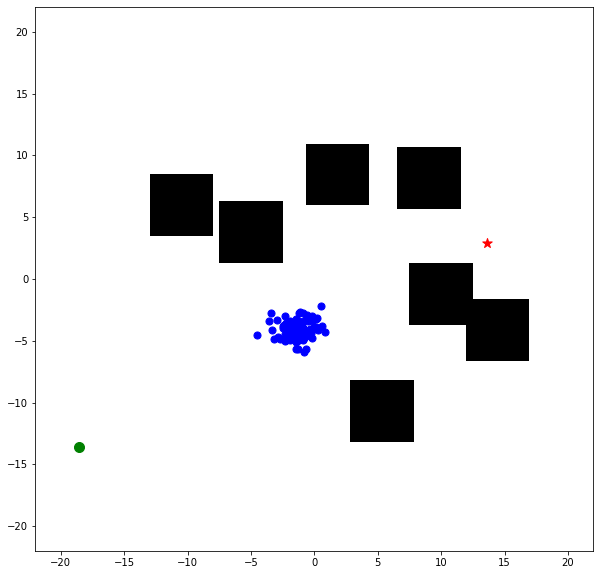

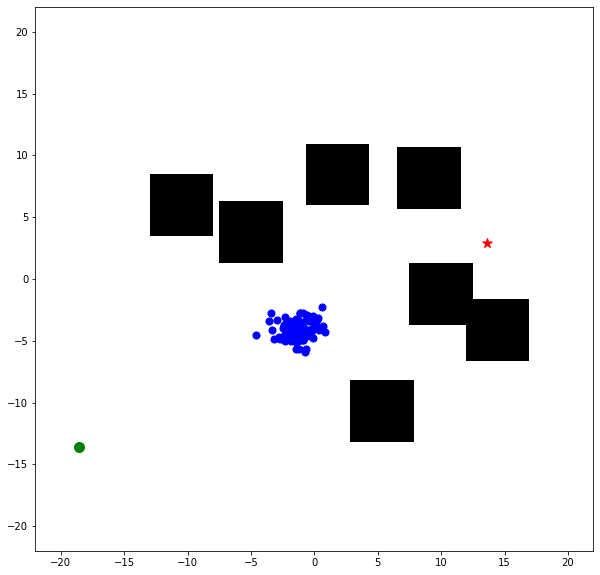

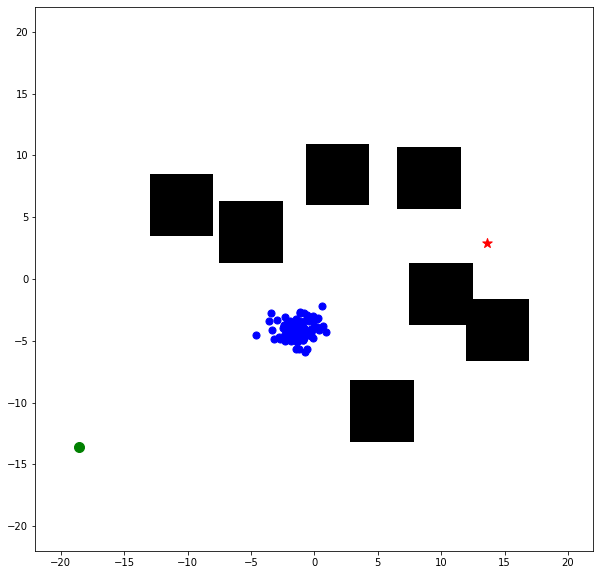

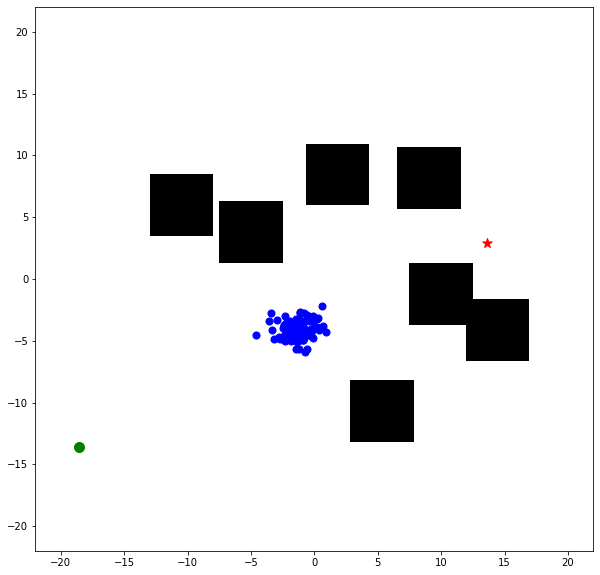

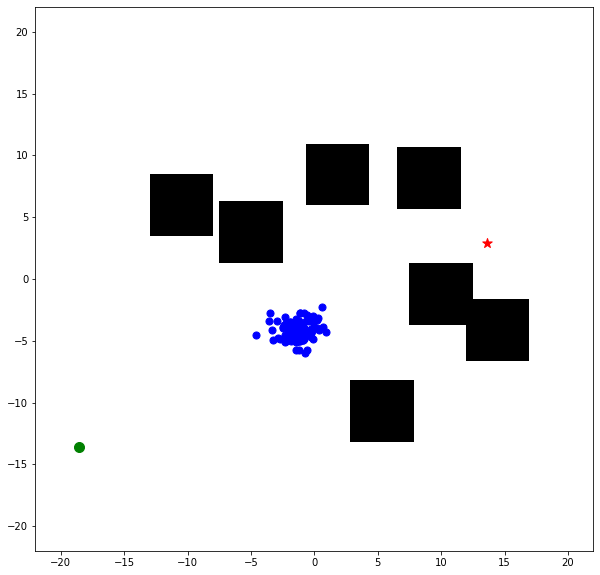

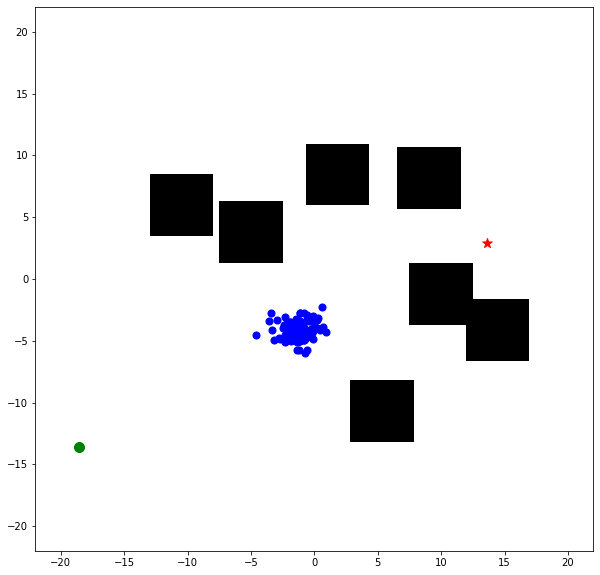

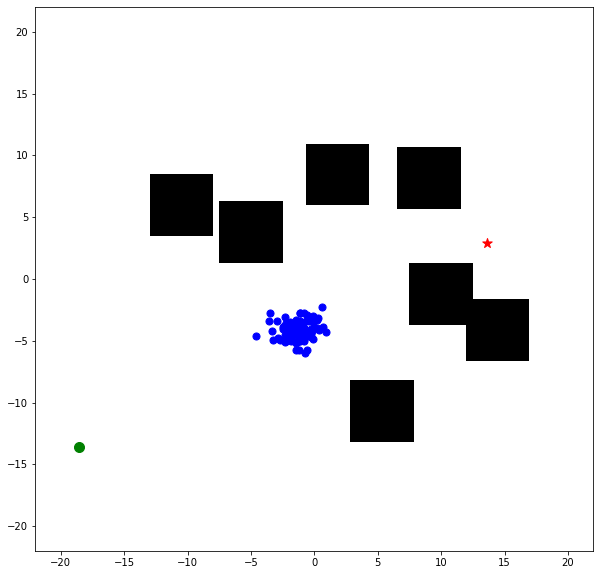

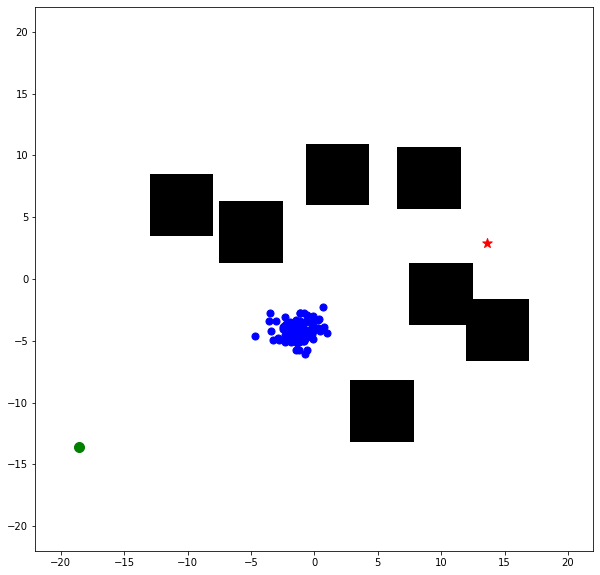

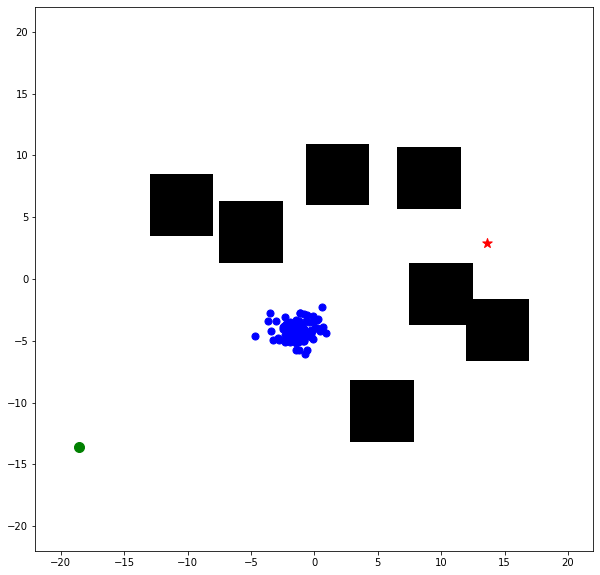

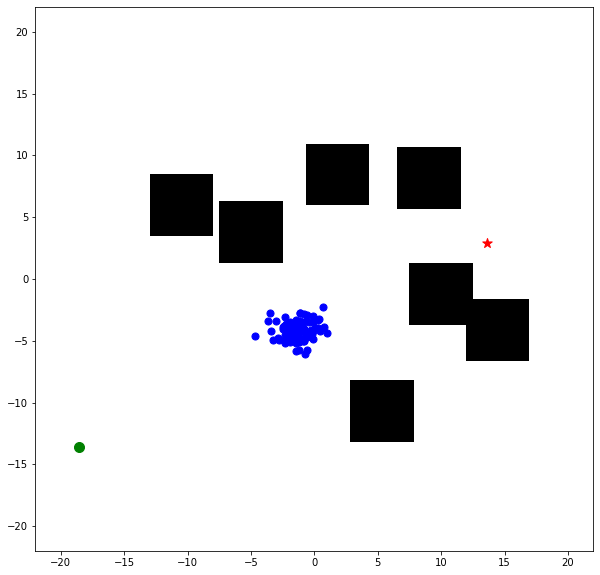

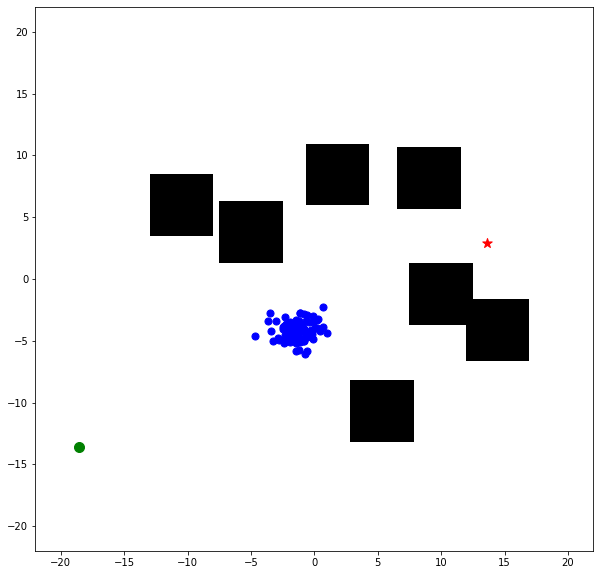

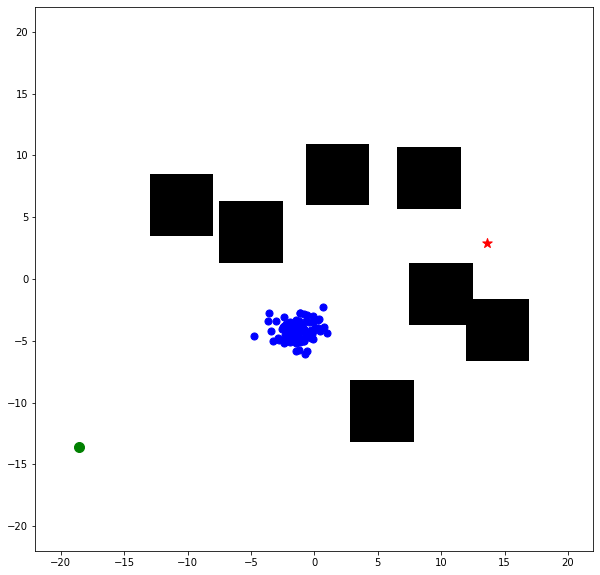

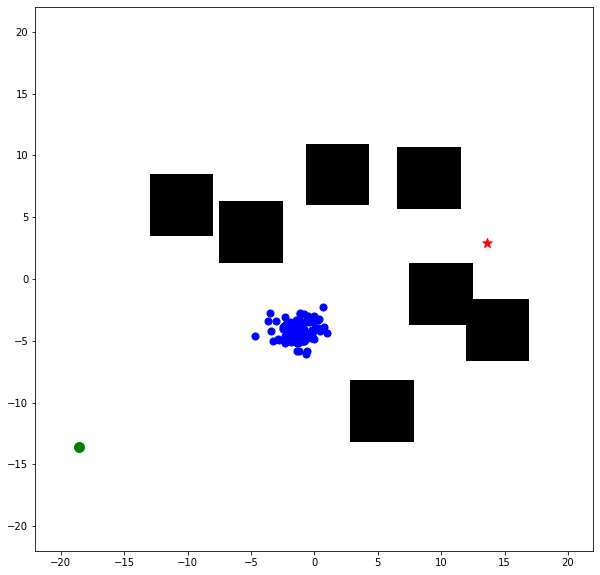

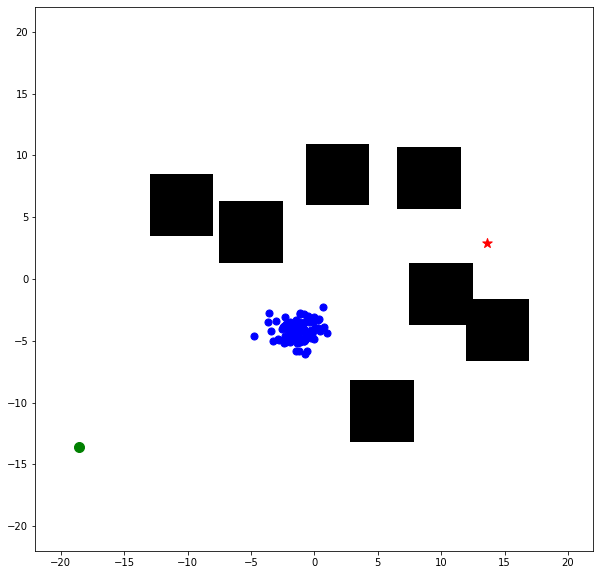

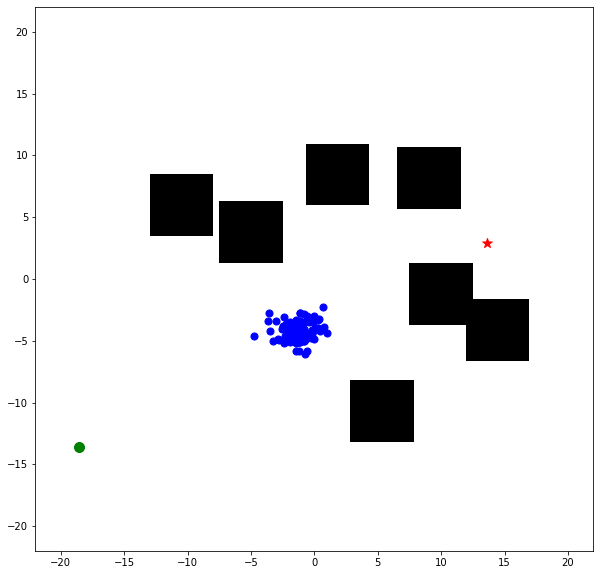

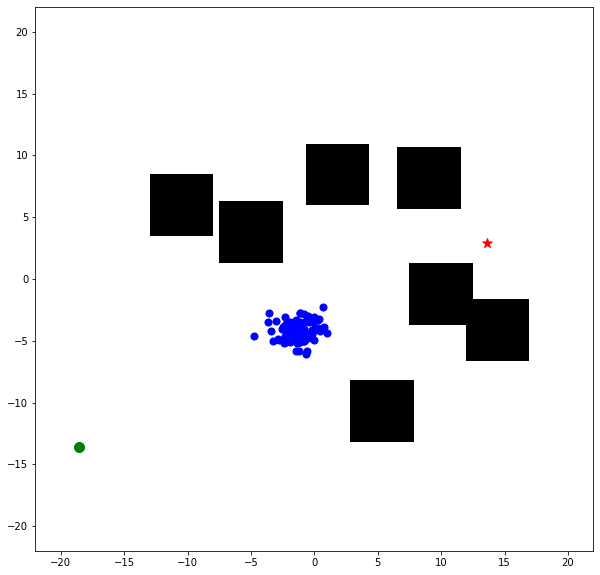

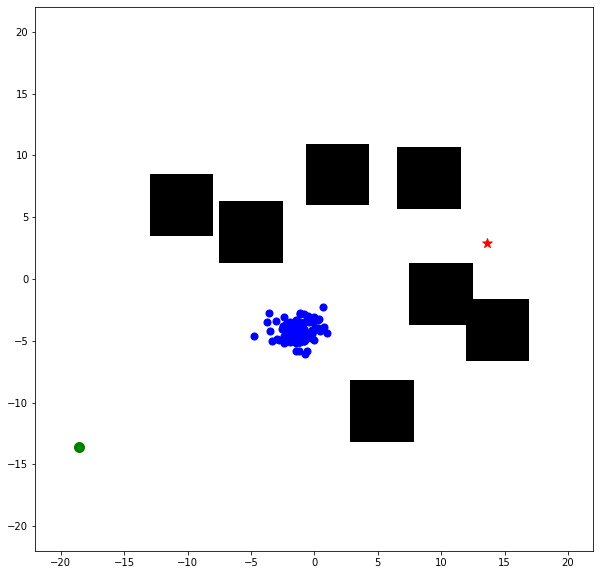

In [15]:
# save figure for different model
for model_f in model_fs:
    smpnet = SMPNet(e_net, cvae)
    smpnet.eval()
    model_path=model_f
    load_net_state(smpnet, os.path.join(model_dir, model_path))
    torch_seed, np_seed, py_seed = load_seed(os.path.join(model_dir, model_path))
    # set seed after loading
    torch.manual_seed(torch_seed)
    np.random.seed(np_seed)
    random.seed(py_seed)

    if torch.cuda.is_available():
        smpnet.cuda()
        smpnet.cvae.cuda()
        smpnet.e_net.cuda()
    fig = cvae_visualization(smpnet, obs_idx, path_idx, num_sample=100);
    plt.savefig("plots/env_%d_path_%d_%s.png" % (obs_idx+args.s, path_idx+args.sp, model_f[:-4]));

In [16]:
!pip install imageio

In [17]:
import imageio
def make_video(obs_idx, path_idx):
    def tryint(s):
        try:
            return int(s)
        except ValueError:
            return s
    def str2int(v_str):
        idx = v_str.split('epoch_')[1]
        idx = int(idx[:-4])
        return idx
    def get_epoch_itr(v_str):
        idx = v_str.split('epoch_')[1]
        idx = idx.split('_iter_')
        epoch = int(idx[0])
        itr = int(idx[1][:-4])
        return (epoch, itr)

    def sort_humanly(v_list):
        return sorted(v_list, key=get_epoch_itr)
    image_folder = 'plots'
    video_name = 'video/env_{}_{}.gif'.format(obs_idx, path_idx)
    images = [img for img in os.listdir(image_folder) if 'env_%d_path_%d' % (obs_idx, path_idx) in img and 'iter' in img]
    images = sort_humanly(images)
    imgs = []
    for filename in images:
#         print('./'+image_folder+'/'+filename)
        imgs.append(imageio.imread('./'+image_folder+'/'+filename))
    imageio.mimsave(video_name, imgs)

In [18]:
make_video(obs_idx+args.s, path_idx+args.sp)